In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarning


In [2]:
# Load cleaned data
df = pd.read_csv('../data/cleaned_data.csv')

### RFM Features

#### 1. Recency (R)

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create new column InvoiceDay
df['InvoiceDay'] = df['InvoiceDate'].dt.date
df['InvoiceDay'] = pd.to_datetime(df['InvoiceDay'])

# Find most recent transacted date of each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date from the whole dataset a.k.a the "now" date for recency calculation:
max_dt = df['InvoiceDay'].max()
max_dt = pd.to_datetime(max_dt)

# Calculate Recency a.k.a Days_Since_Last_Transaction
customer_data['Days_Since_Last_Transaction'] = (max_dt - customer_data['InvoiceDay']).dt.days

# Finally, drop the InvoiceDay column
customer_data.drop('InvoiceDay', axis=1, inplace=True)

# Display the first 5 rows
display(customer_data.head())

,CustomerID,Days_Since_Last_Transaction
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


#### 2. Frequency (F)

In [4]:
# Calculate the total of each customer's number of orders (using unique InvoiceNo):
order_counts = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
order_counts.rename(columns={'InvoiceNo': 'Total_Orders_Count'}, inplace=True)

# Calculate the total of each customer's number of product bought:
product_counts = df.groupby('CustomerID')['Quantity'].sum().reset_index()
product_counts.rename(columns={'Quantity': 'Total_Prod_Purchased'}, inplace=True)

# Join 2 dataframes above to customer_data:
customer_data = customer_data.merge(order_counts, on='CustomerID')
customer_data = customer_data.merge(product_counts, on='CustomerID')

display(customer_data.head())

,CustomerID,Days_Since_Last_Transaction,Total_Orders_Count,Total_Prod_Purchased
0,12346,325,2,0
1,12347,2,7,2458
2,12348,75,4,2332
3,12349,18,1,630
4,12350,310,1,196


#### 3. Monetary (M)

In [5]:
# Creating new row: Total_Spent
df['Total_Spent'] = df['UnitPrice'] * df['Quantity']
customer_spent = df.groupby('CustomerID')['Total_Spent'].sum().reset_index()

# Calculate average order value = Total_Spent / Total_Orders_Count: 
aov = customer_spent.merge(order_counts, on='CustomerID')
aov['Avg_Order_Value'] = (aov['Total_Spent'] / aov['Total_Orders_Count']).round(3)

# Merge to customer_data:
customer_data = customer_data.merge(customer_spent, on='CustomerID')
customer_data = customer_data.merge(aov[['CustomerID', 'Avg_Order_Value']], on='CustomerID')

display(customer_data.head())

,CustomerID,Days_Since_Last_Transaction,Total_Orders_Count,Total_Prod_Purchased,Total_Spent,Avg_Order_Value
0,12346,325,2,0,0.00,0.000
1,12347,2,7,2458,4310.00,615.714
2,12348,75,4,2332,1437.24,359.310
3,12349,18,1,630,1457.55,1457.550
4,12350,310,1,196,294.40,294.400


### Product Diversity

#### Product Diversity in Customer's Orders:

In [6]:
# Count number of unique products bought per customer: 
unique_product_counts = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_product_counts.columns = ['CustomerID', 'Uniq_Prod_Purchased_Count']

# Merge to customer_data:
customer_data = customer_data.merge(unique_product_counts, on='CustomerID')

display(customer_data.head())

,CustomerID,Days_Since_Last_Transaction,Total_Orders_Count,Total_Prod_Purchased,Total_Spent,Avg_Order_Value,Uniq_Prod_Purchased_Count
0,12346,325,2,0,0.00,0.000,1
1,12347,2,7,2458,4310.00,615.714,103
2,12348,75,4,2332,1437.24,359.310,21
3,12349,18,1,630,1457.55,1457.550,72
4,12350,310,1,196,294.40,294.400,16


### Purchase Behavioral Features

#### Avg. Days between Purchases

In [7]:
# Get day of week from InvoiceDate:
df['Day_of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Count average days between Order:
unique_cust_id = df['CustomerID'].unique()
# t_unique_cust_id = [14957, 14622, 17695, 17841]
avg_days_btw_purchase = []

for cust_id in unique_cust_id:
    cust_data = df[df['CustomerID'] == cust_id]
    cust_data = cust_data.sort_values(by='InvoiceDate', ascending=False)
    agg_order = cust_data.groupby(['InvoiceNo', 'InvoiceDay'])['TotalPrice'].sum().reset_index()
    agg_order = agg_order['InvoiceDay'].diff().dropna().abs()
    cust_avg_days_btw_order = agg_order.dt.days.mean()
    cust_avg_days = {'CustomerID': cust_id, 'Avg_Days_Btw_Order': cust_avg_days_btw_order}
    avg_days_btw_purchase.append(cust_avg_days)

avg_days_btw_purchase = pd.DataFrame(avg_days_btw_purchase).round(2)
avg_days_btw_purchase.fillna(0, inplace=True)

In [8]:
avg_days_btw_purchase

,CustomerID,Avg_Days_Btw_Order
0,17850,2.09
1,13047,59.27
2,12583,28.81
3,13748,69.50
4,15100,22.20
...,...,...
4357,13436,0.00
4358,15520,0.00
4359,13298,0.00
4360,14569,0.00


#### Favorite Shopping Day of Week


In [9]:
# Find the day of week (dow) with the most transactions:
most_trans_dow = df.groupby(['CustomerID', 'Day_of_Week']).size().reset_index(name='Transaction_Count')
most_trans_dow = most_trans_dow.loc[most_trans_dow.groupby('CustomerID')['Transaction_Count'].idxmax()]
most_trans_dow.rename(columns={'Day_of_Week': 'Fav_DoW'}, inplace=True)
most_trans_dow = most_trans_dow[['CustomerID', 'Fav_DoW']]
display(most_trans_dow.head(10))

,CustomerID,Fav_DoW
0,12346,1
2,12347,1
6,12348,3
8,12349,0
9,12350,2
10,12352,1
13,12353,3
14,12354,3
15,12355,0
16,12356,1


#### Favorite Shopping Hour of Day

In [10]:
most_trans_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Transaction_Count')
most_trans_hour = most_trans_hour.loc[most_trans_hour.groupby('CustomerID')['Transaction_Count'].idxmax()]
most_trans_hour.rename(columns={'Hour': 'Fav_Hour'}, inplace=True)
most_trans_hour = most_trans_hour[['CustomerID', 'Fav_Hour']]
display(most_trans_hour.head(10))

,CustomerID,Fav_Hour
0,12346,10
5,12347,14
9,12348,19
10,12349,9
11,12350,16
13,12352,14
15,12353,17
16,12354,13
17,12355,13
19,12356,9


In [11]:
### Merge all information above to customer_data:
customer_data = pd.merge(customer_data, avg_days_btw_purchase, on='CustomerID')
customer_data = pd.merge(customer_data, most_trans_dow, on='CustomerID')
customer_data = pd.merge(customer_data, most_trans_hour, on='CustomerID')

In [12]:
customer_data

,CustomerID,Days_Since_Last_Transaction,Total_Orders_Count,Total_Prod_Purchased,Total_Spent,Avg_Order_Value,Uniq_Prod_Purchased_Count,Avg_Days_Btw_Order,Fav_DoW,Fav_Hour
0,12346,325,2,0,0.00,0.000,1,0.00,1,10
1,12347,2,7,2458,4310.00,615.714,103,60.83,1,14
2,12348,75,4,2332,1437.24,359.310,21,94.33,3,19
3,12349,18,1,630,1457.55,1457.550,72,0.00,0,9
4,12350,310,1,196,294.40,294.400,16,0.00,2,16
...,...,...,...,...,...,...,...,...,...,...
4357,18280,277,1,45,180.60,180.600,10,0.00,0,9
4358,18281,180,1,54,80.82,80.820,7,0.00,6,10
4359,18282,7,3,98,176.60,58.867,12,117.00,4,13
4360,18283,3,16,1355,2039.58,127.474,262,22.27,3,14


#### Geographical Feature ("Where are the orders coming from")

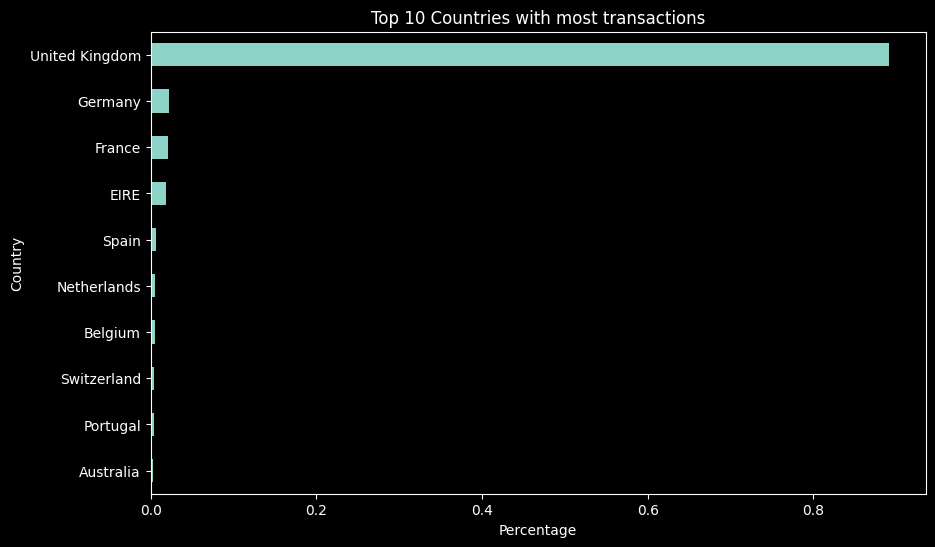

In [13]:
# Where are the orders coming from
df['Country'].value_counts(normalize=True).head(10).sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Countries with most transactions')
plt.xlabel('Percentage')
plt.ylabel('Country')
plt.show()

In [14]:
# We create a new feature called "is_UK" to indicate whether the customer is from UK or not:

cust_by_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Transaction_Count')

# If a customer buys from more than 1 country, we select the country with the most transactions:
cust_by_country = cust_by_country.loc[cust_by_country.groupby('CustomerID')['Transaction_Count'].idxmax()]

cust_by_country['is_UK'] = cust_by_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)
cust_by_country = cust_by_country[['CustomerID', 'is_UK']]

# Merge to customer_data:
customer_data = pd.merge(customer_data, cust_by_country, on='CustomerID')
display(customer_data.head())

,CustomerID,Days_Since_Last_Transaction,Total_Orders_Count,Total_Prod_Purchased,Total_Spent,Avg_Order_Value,Uniq_Prod_Purchased_Count,Avg_Days_Btw_Order,Fav_DoW,Fav_Hour,is_UK
0,12346,325,2,0,0.00,0.000,1,0.00,1,10,1
1,12347,2,7,2458,4310.00,615.714,103,60.83,1,14,0
2,12348,75,4,2332,1437.24,359.310,21,94.33,3,19,0
3,12349,18,1,630,1457.55,1457.550,72,0.00,0,9,0
4,12350,310,1,196,294.40,294.400,16,0.00,2,16,0


#### Order Cancellation Insights

In [ ]:
# Calculate Cancellation Count:

# First, we create "Transaction_Status" column to indicate whether the transaction is cancelled or not:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Not Cancelled')

# Calculate the number of cancelled transactions per customer:
cancel_freq = df[df['Transaction_Status'] == 'Cancelled'].groupby('CustomerID').size().reset_index(name='Cancellation_Count')

# Merge to customer_data:
customer_data = pd.merge(customer_data, cancel_freq, on='CustomerID', how='left')
customer_data['Cancellation_Count'] = customer_data['Cancellation_Count'].fillna(0)


# Calculate Cancellation Rate, which is the percentage of cancelled transactions over the total transactions:
trans_count = df.groupby('CustomerID').size().reset_index(name='Total_Transaction_Count')
customer_data = pd.merge(customer_data, trans_count, on='CustomerID')
customer_data['Cancellation_Rate'] = (customer_data['Cancellation_Count'] / customer_data['Total_Transaction_Count']).round(3)

#### Spending Trends

In [48]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate total monthly spending per customer:
cust_monthly_spend = df.groupby(['CustomerID', 'Year', 'Month'])['TotalPrice'].sum().reset_index()

# Customer Avg. and Std. Monthly Spending:
cust_buying_pattern = cust_monthly_spend.groupby('CustomerID')['TotalPrice'].agg(['mean', 'std']).reset_index()
cust_buying_pattern.rename(columns={'mean': 'Avg_Monthly_Spending', 'std': 'Std_Monthly_Spending'}, inplace=True)
cust_buying_pattern['Std_Monthly_Spending'] = cust_buying_pattern['Std_Monthly_Spending'].fillna(0)
cust_buying_pattern = cust_buying_pattern.round(3)
display(cust_buying_pattern.head())

,CustomerID,Avg_Monthly_Spending,Std_Monthly_Spending
0,12346,0.000,0.000
1,12347,615.714,341.071
2,12348,359.310,203.876
3,12349,1457.550,0.000
4,12350,294.400,0.000


In [49]:
# Calculate each customer spending trend using linear regression:
def calculate_trend(data):
    if len(data) > 1:
        x = np.arange(len(data))
        slope, _, _, _, _ = stats.linregress(x, data)
        return slope
    else:
        return 0

spend_trend = cust_monthly_spend.groupby('CustomerID')['TotalPrice'].apply(calculate_trend).reset_index(name='Monthly_Spending_Trend')


In [52]:
# Merge to customer_data:
customer_data = pd.merge(customer_data, cust_buying_pattern, on='CustomerID')
customer_data = pd.merge(customer_data, spend_trend, on='CustomerID')

customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)
customer_data = customer_data.convert_dtypes()

In [57]:
customer_data.head()

,CustomerID,Days_Since_Last_Transaction,Total_Orders_Count,Total_Prod_Purchased,Total_Spent,Avg_Order_Value,Uniq_Prod_Purchased_Count,Avg_Days_Btw_Order,Fav_DoW,Fav_Hour,is_UK,Cancellation_Count,Total_Transaction_Count,Cancellation_Rate,Avg_Monthly_Spending,Std_Monthly_Spending,Monthly_Spending_Trend
0,12346,325,2,0,0.0,0.0,1,0.0,1,10,1,1,2,0.5,0.0,0.0,0.0
1,12347,2,7,2458,4310.0,615.714,103,60.83,1,14,0,0,182,0.0,615.714,341.071,4.486071
2,12348,75,4,2332,1437.24,359.31,21,94.33,3,19,0,0,27,0.0,359.31,203.876,-100.884
3,12349,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,72,0.0,1457.55,0.0,0.0
4,12350,310,1,196,294.4,294.4,16,0.0,2,16,0,0,16,0.0,294.4,0.0,0.0


In [58]:
# Last step, save the customer_data to a new csv file:
customer_data.to_csv('../data/engineered_customer_data.csv', index=False)